# hetan: ridge regression on macro variables and a basket of related stocks is what i’d suggest

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
import pandas_datareader as pdr
import quantstats as qs
import pytz

import datetime as dt

from sklearn import linear_model

In [3]:
snp_data = pd.read_csv('../Data/Structured_Data/snp500.csv')
snp = pd.Series(snp_data[['Symbol']].squeeze()).tolist()

In [4]:
pd.__version__

'1.4.3'

# Try Hetan's suggestion - rough generalization of pairs trading on multiple assets

In [5]:
# tickerName: string, a single ticker
# period can be '_mo', '_
def downloadClosingPrices(tickerName, period='6mo'):
    return yf.Ticker(tickerName).history(period=period)[['Close']]

# closingPrices: a Pandas Dataframe of closing prices
# returns a list of returns
def getReturns(closingPrices):
    return closingPrices.pct_change(1).dropna() #closingPrices.diff().reset_index(drop=True)[1:].reset_index(drop=True).div(closingPrices[:-1].reset_index(drop=True))

# tickerNames: a list of strings of ticker names
# returns a dictionary of ticker names to lists of their daily returns
def makeDailyReturnsDf(tickerNames, period='6mo'):
    ticker_data = {}
  
    longestIndex = pd.Series(dtype='float64')
    # retrieve data
    for t in tickerNames:
        # take over the past 6 months
        c = downloadClosingPrices(t, period)
        # store longest index
        if len(c.index) >= len(longestIndex):
            longestIndex = c.index[1:]
        # No data found, symbol may be delisted
        if len(c) == 0:
            continue
        else:
            ticker_data[t] = getReturns(c).rename(columns={"Close":t}).squeeze().tolist()
    # remove stocks which are not of the same length
    lens = [len(v) for v in ticker_data.values()]
    longest = max(lens)
    ticker_data_copy = ticker_data.copy()
    for k, v in ticker_data_copy.items():
        if len(v) < longest:
            ticker_data.pop(k)
    # ticker_data
    return pd.DataFrame(ticker_data, index = longestIndex)

# tickersToPredict DOESN'T have to be a subset of tickers
# returns a dictionary with the name of the stock as keys and the LM predicting that stock as values
# trains pair-wise LMs using same-day returns of related stocks as predictors
def trainLM(tickers, tickerToPredict):

    X = makeDailyReturnsDf(tickers)
    y = makeDailyReturnsDf([tickerToPredict])

    lm = Ridge()
    if tickerToPredict in X.columns:
        X.drop(columns=tickerToPredict, inplace=True)
    lm.fit(X, y)
    print(tickerToPredict, lm.score(X, y))
    return lm

In [6]:
# TODO: change to return series?
## zscore fn to generate buy/sell signals on a daily basis
# takes the zscore of a particular day's prediction over a window of past days
# lm: the linear model predicting stock returns based on related stocks
# X: a dataframe of predictors - returns of stocks related to the target
# y: a list of the target stock's returns
# days: number of days back to scale over
def zscore(lm, X, y, days=30):
    # lookback = min(len(X), len(y), days)
    lookback = days
    # print('lookback',lookback)
    steps = len(X)
    z_ts = []
    for s in range(steps,lookback,-1):
        X_window, y_window = X.iloc[s-lookback:s,], y.iloc[s-lookback:s]
        # predict for the last lookback no. of days
        y_hats = lm.predict(X_window)
        # get the residuals
        y_res = y_window - y_hats

        # get residual for today
        y_res_t = y_res.iloc[-1]
        y_res_ex_t = y_res.iloc[:-1]

        scaler = StandardScaler()
        # fit scale based on residuals up to yesterday
        scaler.fit(np.asarray(y_res_ex_t).reshape(-1,1))

        # transform today's residual
        z_t = scaler.transform(np.asarray(y_res_t).reshape(-1,1))
        z_ts.append(z_t[0][0])
    return z_ts

## Make Rolling Regression model (without sentiment)

In [7]:
spy = makeDailyReturnsDf(["SPY"], '4y')
spy

,SPY
Date,
2018-11-09 00:00:00-05:00,-0.009768
2018-11-12 00:00:00-05:00,-0.018685
2018-11-13 00:00:00-05:00,-0.001871
2018-11-14 00:00:00-05:00,-0.006837
2018-11-15 00:00:00-05:00,0.010437
...,...
2022-11-01 00:00:00-04:00,-0.004376
2022-11-02 00:00:00-04:00,-0.025096
2022-11-03 00:00:00-04:00,-0.010297


In [8]:
from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm
from tqdm import tqdm

def logPriceFromRets(yhist):
    return np.log(np.cumprod(1+yhist))

def Model(tickers_to_predict, tickers_as_predictors, window = 120, lookback = 30, thresh = 1, rets = True, intercept = False):
    retsSpreads = []
    for tick in tqdm(tickers_to_predict):
        Xhist = makeDailyReturnsDf([t for t in tickers_as_predictors if t != tick], '4y')
        yhist = makeDailyReturnsDf([tick],'4y')
        Xyhist = pd.concat([Xhist, yhist], axis=1)
        if rets:
            if intercept:
                ols = RollingOLS(yhist, sm.add_constant(Xhist), window=window).fit()
            else:
                ols = RollingOLS(yhist, Xhist, window=window).fit()
            betas = ols.params.dropna()
        else:
            if intercept:
                ols = RollingOLS(logPriceFromRets(yhist), 
                            sm.add_constant(logPriceFromRets(Xhist)), window=window).fit()
            else:
                ols = RollingOLS(logPriceFromRets(yhist), 
                            logPriceFromRets(Xhist), window=window).fit()
            betas = ols.params.dropna()
        if intercept:
            if rets:
                spread = yhist[tick] - (betas * sm.add_constant(Xhist)).sum(1)
            else:
                spread = logPriceFromRets(yhist[tick]) - (betas * sm.add_constant(logPriceFromRets(Xhist))).sum(1)
            weights = sm.add_constant(betas.drop('const', axis=1)).rename({'const':tick}, axis=1)
            weights = weights.div(weights.abs().sum(1), axis=0)
        else:
            if rets:
                spread = yhist[tick] - (betas * (Xhist)).sum(1)
            else:
                spread = logPriceFromRets(yhist[tick]) - (betas * logPriceFromRets(Xhist)).sum(1)
            weights = sm.add_constant(betas).rename({'const':tick}, axis=1)
            weights = weights.div(weights.abs().sum(1), axis=0)
        print('ols.rsquared', ols.rsquared)
        zscore = (spread - spread.ewm(lookback).mean())/spread.ewm(lookback).std()
        signals = -(zscore>thresh).astype(int) + (zscore<thresh).astype(int)
        retsSpreads.append((weights.mul(signals,0).shift(1) * 
                            Xyhist.reindex(betas.index).dropna()).sum(1))
    retsSpreads = pd.DataFrame(retsSpreads).T.reindex(betas.index).dropna().reset_index()

    retsSpreads['Date'] = retsSpreads['Date'].dt.tz_localize(None)
    retsSpreads.index = retsSpreads['Date']
    retsSpreads.drop(columns=['Date'], inplace=True)
    qs.reports.full(retsSpreads.mean(1), rf=0.02)
# , benchmark='SPY', match_dates=True)

# Compile lists of relevant stocks

In [9]:
snp_data[:10]

,Symbol,Description,Category2,Category3,GICS Sector,Market cap,Dividend yield,Price to TTM earnings,Price to TTM sales,Price to book value,Action
0,AAPL,Apple Inc,Common stocks,Large cap,Information Technology,"$2,396,557,976,700",0.60%,21.67,6.21,32.78,Analyze
1,MSFT,Microsoft Corp,Common stocks,Large cap,Information Technology,"$1,700,887,137,266",1.08%,22.04,8.83,9.80,Analyze
2,GOOG,Alphabet Inc Class C,Common stocks,Large cap,Communication Services,"$1,091,160,310,000",0.00%,6.82,4.04,2.00,Analyze
3,GOOGL,Alphabet Inc Class A,Common stocks,Large cap,Communication Services,"$1,091,160,310,000",0.00%,6.69,4.04,1.96,Analyze
4,AMZN,Amazon.Com Inc.,Common stocks,Large cap,Consumer Discretionary,"$987,418,107,695",0.00%,42.54,2.07,6.80,Analyze
5,TSLA,Tesla Inc,Common stocks,Large cap,Consumer Discretionary,"$713,867,145,652",0.00%,80.33,11.48,19.79,Analyze
6,BRK.B,Berkshire Hathaway Inc. Class B,Common stocks,Large cap,Financials,"$648,469,030,904",0.00%,4.42,1.83,0.71,Analyze
7,UNH,Unitedhealth Group Inc,Common stocks,Large cap,Health Care,"$511,944,311,010",1.13%,29.14,1.73,6.99,Analyze
8,XOM,Exxon Mobil Corp,Common stocks,Large cap,Energy,"$466,400,177,773",3.10%,17.95,1.52,2.74,Analyze
9,JNJ,Johnson & Johnson,Common stocks,Large cap,Health Care,"$452,540,967,536",2.51%,22.51,4.77,5.97,Analyze


Some of the top tech stocks like Google are classified as "Communication Services", so we include those

In [10]:
top20_it_stocks = snp_data[snp_data['GICS Sector'] == 'Information Technology']['Symbol'].to_list()[:20]
top20_stocks = snp_data['Symbol'].to_list()[:20]
top20_comm_stocks = snp_data[snp_data['GICS Sector']=='Communication Services']['Symbol'].to_list()[:20]
top20_it_comm_stocks = snp_data[snp_data['GICS Sector'].isin(['Information Technology', 'Communication Services'])]['Symbol'].to_list()[:20]

In [11]:
top20_it_comm_stocks

['AAPL',
 'MSFT',
 'GOOG',
 'GOOGL',
 'V',
 'NVDA',
 'MA',
 'META',
 'ORCL',
 'DIS',
 'AVGO',
 'TMUS',
 'ACN',
 'CSCO',
 'CRM',
 'VZ',
 'TXN',
 'ADBE',
 'CMCSA',
 'QCOM']

100%|██████████| 1/1 [00:02<00:00,  2.78s/it]

ols.rsquared Date
2018-11-09 00:00:00-05:00    NaN
2018-11-12 00:00:00-05:00    NaN
2018-11-13 00:00:00-05:00    NaN
2018-11-14 00:00:00-05:00    NaN
2018-11-15 00:00:00-05:00    NaN
                            ... 
2022-11-01 00:00:00-04:00    1.0
2022-11-02 00:00:00-04:00    1.0
2022-11-03 00:00:00-04:00    1.0
2022-11-04 00:00:00-04:00    1.0
2022-11-07 00:00:00-05:00    1.0
Length: 1005, dtype: float64


                           Strategy
-------------------------  ----------
Start Period               2019-05-06
End Period                 2022-11-07
Risk-Free Rate             2.0%
Time in Market             100.0%

Cumulative Return          170.65%
CAGR﹪                     32.8%

Sharpe                     0.93
Prob. Sharpe Ratio         89.51%
Smart Sharpe               0.81
Sortino                    1.36
Smart Sortino              1.18
Sortino/√2                 0.96
Smart Sortino/√2           0.83
Omega                      1.18

Max Drawdown               -31.57%
Longest DD Days            307
Volatility (ann.)          34.78%
Calmar                     1.04
Skew                       -0.04
Kurtosis                   4.45

Expected Daily %           0.11%
Expected Monthly %         2.34%
Expected Yearly %          28.26%
Kelly Criterion            8.39%
Risk of Ruin               0.0%
Daily Value-at-Risk        -3.47%
Expected Shortfall (cVaR)  -3.47%

Max Consecutive Wins    

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2022-01-04,2022-06-16,2022-11-07,307,-31.572667,-30.152145
2,2020-02-13,2020-03-23,2020-06-05,113,-31.426286,-29.937917
3,2020-09-02,2020-09-18,2020-12-28,117,-20.375308,-20.166623
4,2021-01-27,2021-03-08,2021-07-07,161,-18.598267,-16.065911
5,2019-05-07,2019-06-03,2019-07-23,77,-16.553921,-15.701685


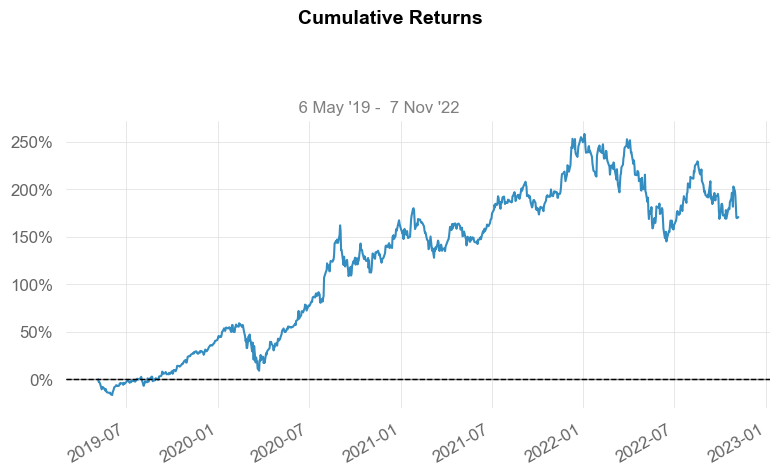

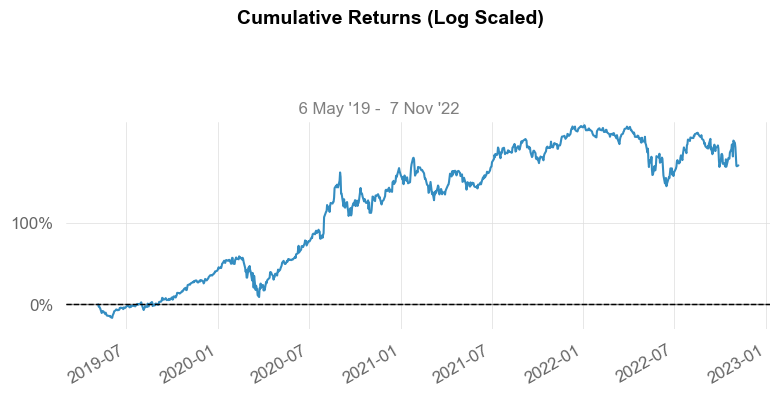

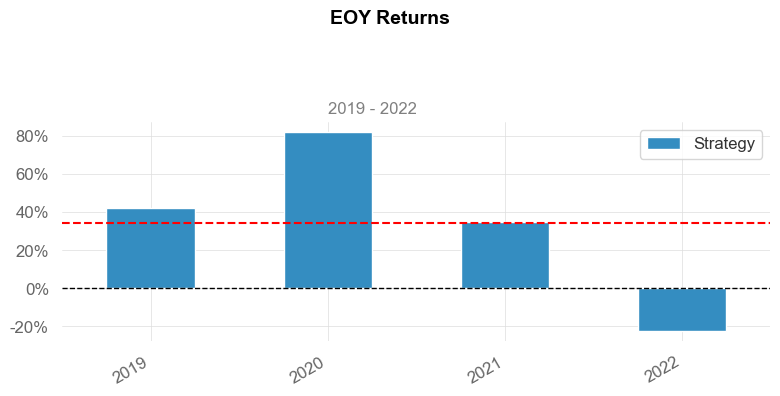

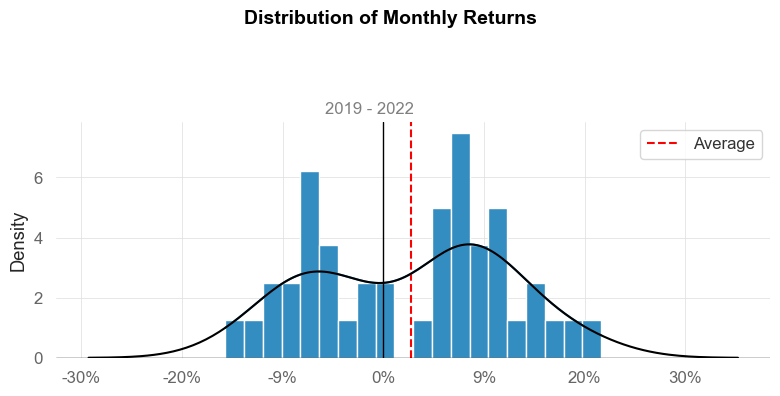

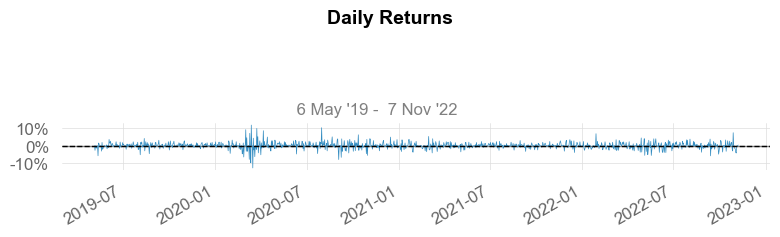

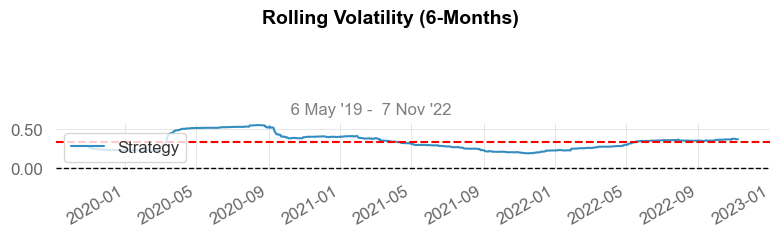

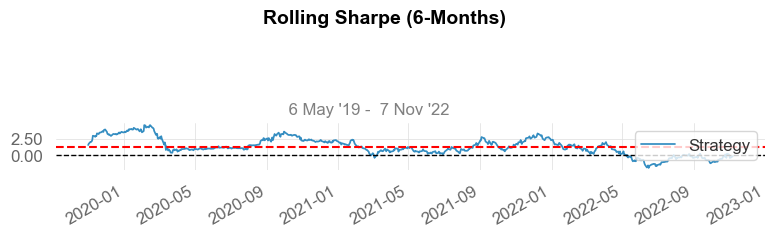

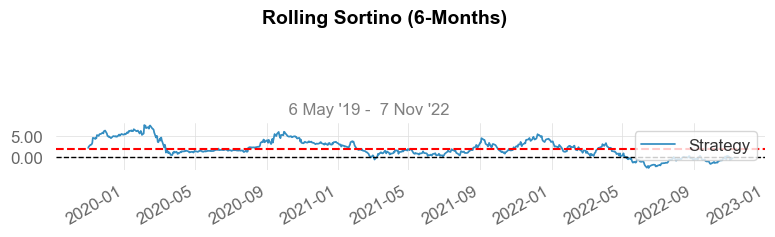

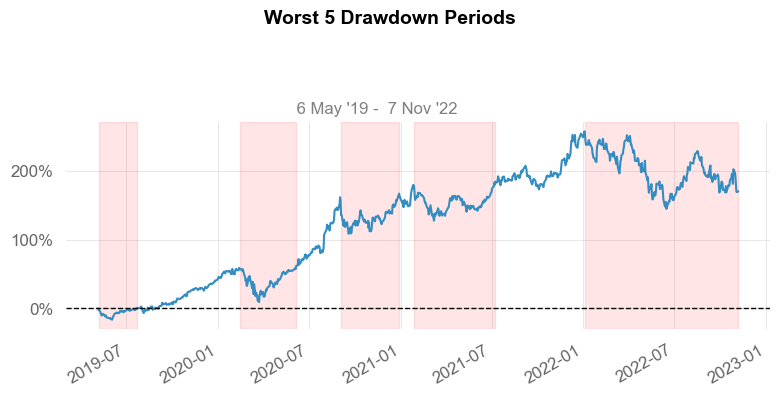

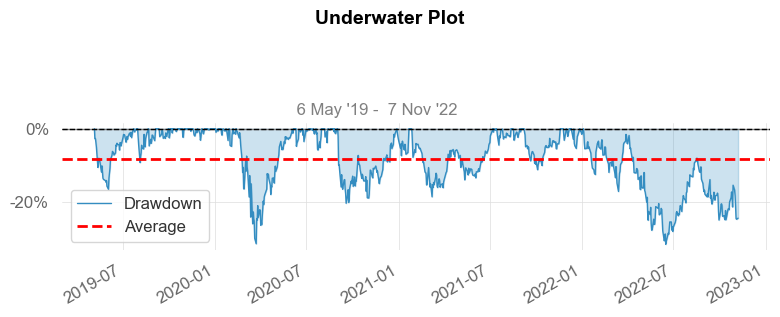

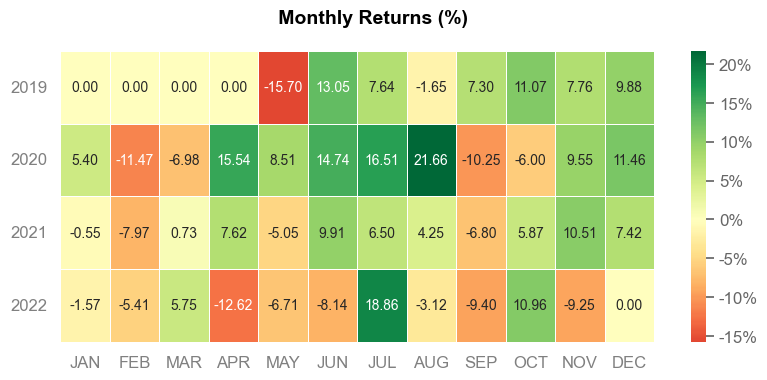

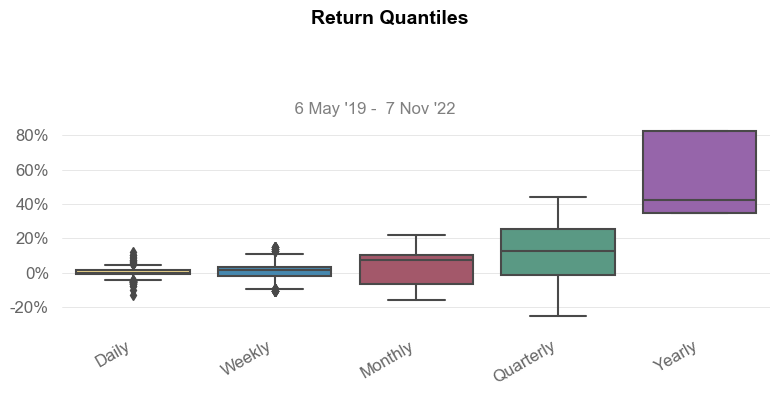

In [12]:
Model(['AAPl'], top20_it_comm_stocks)

# Try Model with incorporation of sentiment

cache returns data into csvs so that we don't get the newest data from dynamic calls to yahoo finance. This allows us to match the dates with those from the predictions from the sentiment analyses techniques which are also not dynamic and stored in csvs.

In [13]:
top20_it_stocks_df = makeDailyReturnsDf(top20_it_stocks, '1y')
top20_it_stocks_df.to_csv('../Data/Structured_Data/top20_it_stocks.csv')
top20_it_comm_stocks_df = makeDailyReturnsDf(top20_it_comm_stocks, '1y')
top20_it_comm_stocks_df.to_csv('../Data/Structured_Data/top20_it_comm_stocks.csv')

In [14]:
AAPL = makeDailyReturnsDf(['AAPL'], '1y')
AAPL.to_csv('../Data/Structured_Data/AAPL.csv')
TSLA = makeDailyReturnsDf(['TSLA'], '1y')
TSLA.to_csv('../Data/Structured_Data/TSLA.csv')
META = makeDailyReturnsDf(['META'], '1y')
META.to_csv('../Data/Structured_Data/META.csv')

In [15]:
def readDailyReturnsFromCsv(tickerNames, period='6mo', filepath='../Data/Structured_Data/'):
    ticker_data = {}
    longestIndex = pd.Series(dtype='float64')
    for t in tickerNames:
        df = pd.read_csv(filepath+t+'.csv', index_col=0, parse_dates=True, infer_datetime_format=True)
        df.index = pd.to_datetime(df.index, utc=True).date
        df.index.rename('Date', inplace=True)
        ticker_data[t] = df
        if df.shape[0] >= len(longestIndex):
            longestIndex = df.index[1:]
    lens = [len(v) for v in ticker_data.values()]
    longest = max(lens)
    ticker_data_copy = ticker_data.copy()
    for k, v in ticker_data_copy.items():
        if len(v) < longest:
            ticker_data.pop(k)
    combined = pd.concat(list(ticker_data.values()))
    return combined
    

In [16]:
readDailyReturnsFromCsv(['TSLA',])

,TSLA
Date,
2021-11-09,-0.119903
2021-11-10,0.043429
2021-11-11,-0.004158
2021-11-12,-0.028293
2021-11-15,-0.019382
...,...
2022-11-01,0.001231
2022-11-02,-0.056360
2022-11-03,0.001535


In [17]:
from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm
from tqdm import tqdm

def logPriceFromRets(yhist):
    return np.log(np.cumprod(1+yhist))

def ModelwSentiment(tickers_to_predict=['AAPL'], 
        tickers_as_predictors=['top20_it_comm_stocks'], 
        sentiment_filepath = '../Data/3_Predictions/Unstructured_Data/rf_regressor/returns', sentiment_file = '/finbert_pred_returns_rfr_test.csv', 
        window = 120, lookback = 30, thresh = 1, rets = True, intercept = False):
    retsSpreads = []
    for tick in tqdm(tickers_to_predict):
        #TODO: read from csv file instead of pulling live data to match the sentiment predictions by Elton
        # yhist = pd.read_csv('../Data/Structured_Data/aapl.csv',index_col=0, parse_dates=True, infer_datetime_format=True)
        yhist = readDailyReturnsFromCsv(tickers_to_predict)
        yhist.index = pd.to_datetime(yhist.index, utc=True).date
        yhist.index.rename('Date', inplace=True)


        # returns data
        # Xhist_rets = pd.read_csv('../Data/Structured_Data/top20_it_comm_stocks_df.csv',index_col=0, parse_dates=True, infer_datetime_format=True)
        Xhist_rets = readDailyReturnsFromCsv(tickers_as_predictors)
        Xhist_rets.index = pd.to_datetime(Xhist_rets.index, utc=True).date
        Xhist_rets.index.rename('Date', inplace=True)

        # sentiment data
        Xhist_sent = pd.read_csv(sentiment_filepath + sentiment_file, index_col=0)[tickers_to_predict]
        Xhist_sent.index = pd.to_datetime(Xhist_sent.index, utc=True).date
        Xhist_sent.index.rename('Date', inplace=True)

        # merge only on the dates that overlap
        Xhist = Xhist_rets.merge(Xhist_sent, how='inner', left_index=True, right_index=True, suffixes=('_rets','_sent'))
        yhist = yhist.loc[Xhist.index,:]

        Xyhist = pd.concat([Xhist, yhist], axis=1)
        print('Xhist.shape', Xhist.shape)
        print('yhist.shape', yhist.shape)
        print('Xyhist.shape', Xyhist.shape)
        # get betas
        if rets:
            if intercept:
                ols = RollingOLS(yhist, sm.add_constant(Xhist), window=window).fit()
            else:
                #TODO: add sentiment here
                ols = RollingOLS(yhist, Xhist, window=window).fit()
            betas = ols.params.dropna()
        else:
            if intercept:
                ols = RollingOLS(logPriceFromRets(yhist), 
                            sm.add_constant(logPriceFromRets(Xhist)), window=window).fit()
            else:
                ols = RollingOLS(logPriceFromRets(yhist), 
                            logPriceFromRets(Xhist), window=window).fit()
            betas = ols.params.dropna()
        # get weights
        if intercept:
            if rets:
                spread = yhist[tick] - (betas * sm.add_constant(Xhist)).sum(1)
            else:
                spread = logPriceFromRets(yhist[tick]) - (betas * sm.add_constant(logPriceFromRets(Xhist))).sum(1)
            weights = sm.add_constant(betas.drop('const', axis=1)).rename({'const':tick}, axis=1)
            weights = weights.div(weights.abs().sum(1), axis=0)
        else:
            if rets:
                #TODO: add sentiment here
                spread = yhist[tick] - (betas * (Xhist)).sum(1)
            else:
                spread = logPriceFromRets(yhist[tick]) - (betas * logPriceFromRets(Xhist)).sum(1)
            weights = sm.add_constant(betas).rename({'const':tick}, axis=1)
            weights = weights.div(weights.abs().sum(1), axis=0)
        print('ols.rsquared', ols.rsquared)
        zscore = (spread - spread.ewm(lookback).mean())/spread.ewm(lookback).std()
        signals = -(zscore>thresh).astype(int) + (zscore<thresh).astype(int)
        retsSpreads.append((weights.mul(signals,0).shift(1) * 
                            Xyhist.reindex(betas.index).dropna()).sum(1))
    retsSpreads = pd.DataFrame(retsSpreads).T.reindex(betas.index).dropna().reset_index()


    print("retsSpreads.index", retsSpreads.index)
    print("type(retsSpreads.index)", type(retsSpreads.index))
    print("type(retsSpreads['Date'])", type(retsSpreads['Date']))
    print("type(retsSpreads['Date'][0])", type(retsSpreads['Date'][0]))
    retsSpreads['Date'] = pd.DatetimeIndex(retsSpreads['Date']).tz_localize(None)
    retsSpreads.index = retsSpreads['Date']
    retsSpreads.drop(columns=['Date'], inplace=True)
    qs.reports.full(retsSpreads.mean(1), rf=0.02)
# , benchmark='SPY', match_dates=True)

100%|██████████| 1/1 [00:00<00:00,  6.02it/s]


Xhist.shape (172, 21)
yhist.shape (172, 1)
Xyhist.shape (172, 22)
ols.rsquared Date
2021-12-27    NaN
2021-12-28    NaN
2021-12-29    NaN
2021-12-30    NaN
2021-12-31    NaN
             ... 
2022-08-25    1.0
2022-08-26    1.0
2022-08-29    1.0
2022-08-30    1.0
2022-08-31    1.0
Length: 172, dtype: float64
retsSpreads.index RangeIndex(start=0, stop=53, step=1)
type(retsSpreads.index) <class 'pandas.core.indexes.range.RangeIndex'>
type(retsSpreads['Date']) <class 'pandas.core.series.Series'>
type(retsSpreads['Date'][0]) <class 'datetime.date'>


                           Strategy
-------------------------  ----------
Start Period               2022-06-16
End Period                 2022-08-31
Risk-Free Rate             2.0%
Time in Market             99.0%

Cumulative Return          21.05%
CAGR﹪                     150.3%

Sharpe                     3.44
Prob. Sharpe Ratio         92.81%
Smart Sharpe               3.36
Sortino                    6.0
Smart Sortino              5.86
Sortino/√2                 4.24
Smart Sortino/√2           4.14
Omega                      1.74

Max Drawdown               -9.93%
Longest DD Days            13
Volatility (ann.)          26.87%
Calmar                     15.14
Skew                       -0.02
Kurtosis                   -0.31

Expected Daily %           0.36%
Expected Monthly %         6.58%
Expected Yearly %          21.05%
Kelly Criterion            23.3%
Risk of Ruin               0.0%
Daily Value-at-Risk        -2.41%
Expected Shortfall (cVaR)  -2.41%

Max Consecutive Wins      

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2022-08-18,2022-08-31,2022-08-31,13,-9.928321,-8.960117
2,2022-06-28,2022-06-30,2022-07-06,8,-3.487188,-2.978929
3,2022-07-22,2022-07-26,2022-07-27,5,-2.413888,-1.544890
4,2022-07-18,2022-07-18,2022-07-19,1,-2.064303,0.000000
5,2022-08-01,2022-08-02,2022-08-03,2,-1.538357,-0.615341


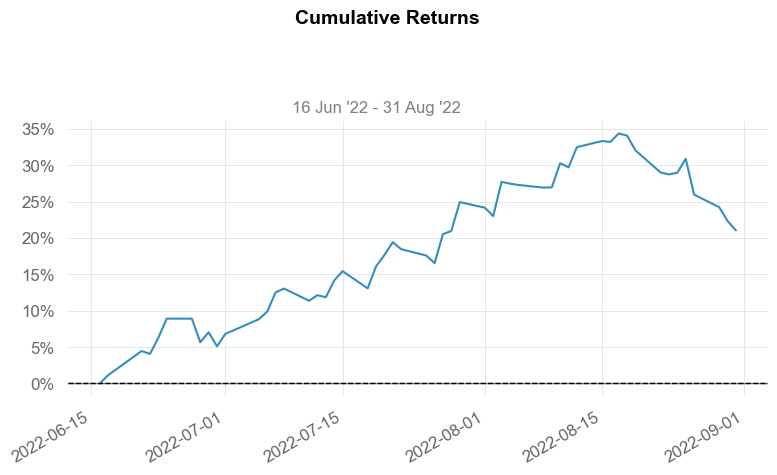

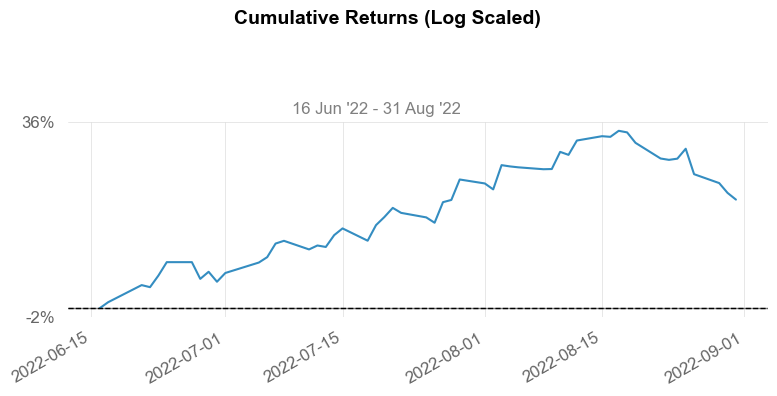

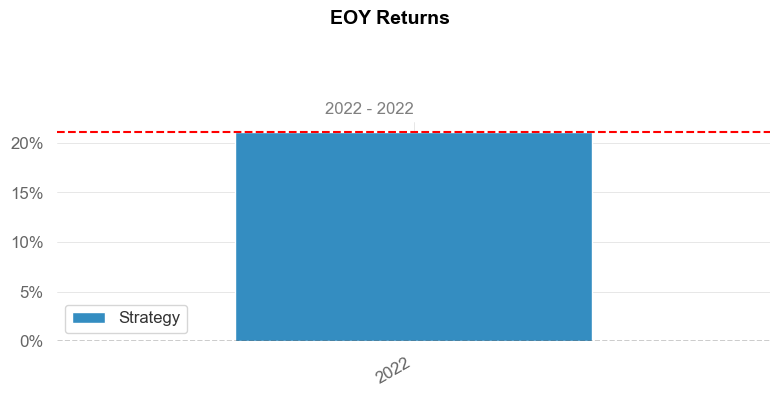

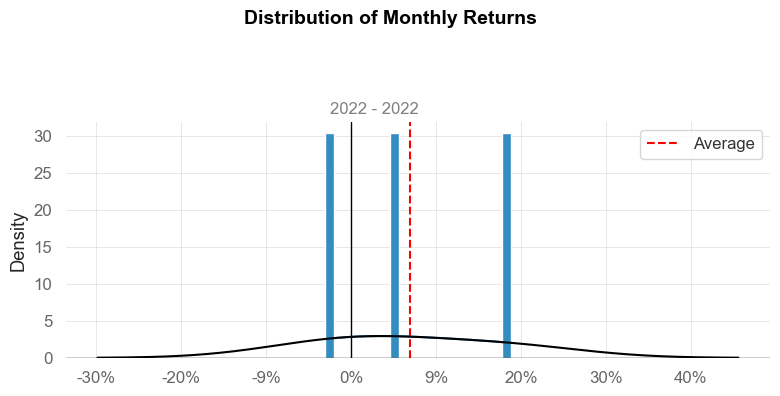

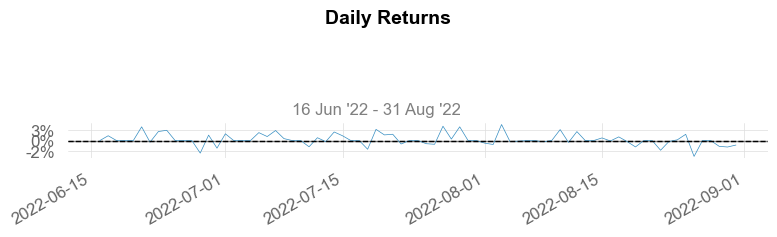

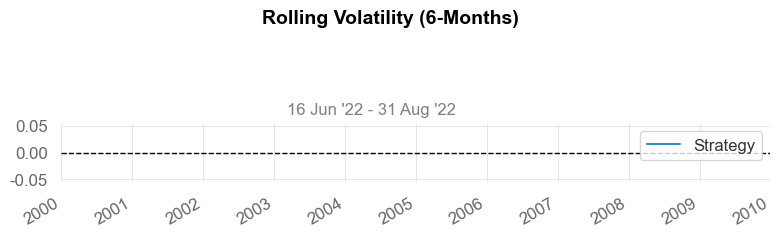

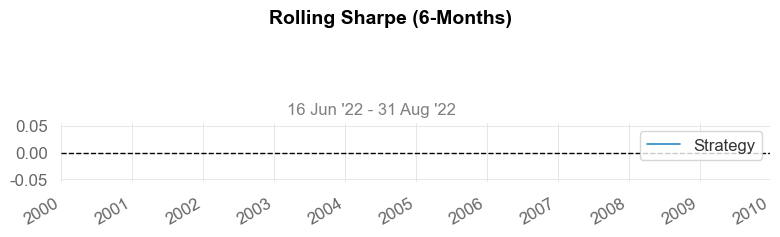

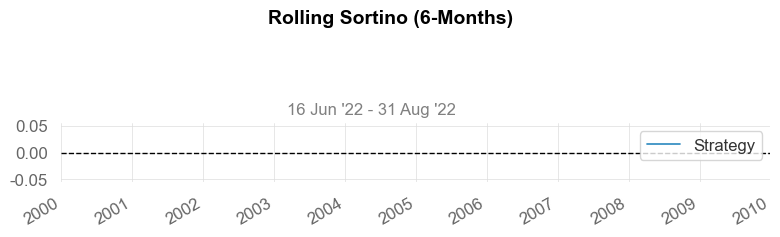

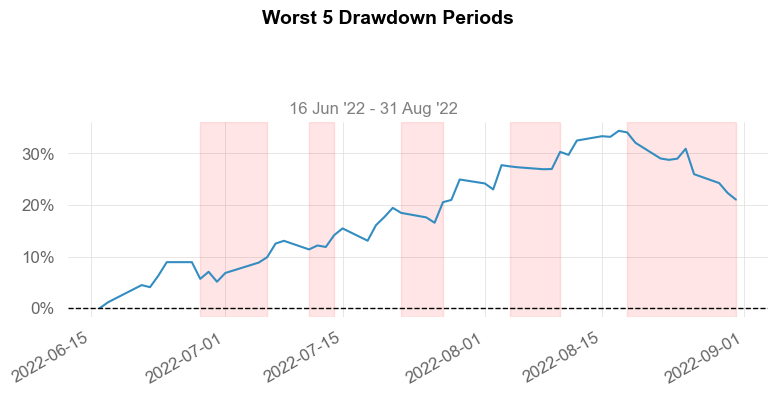

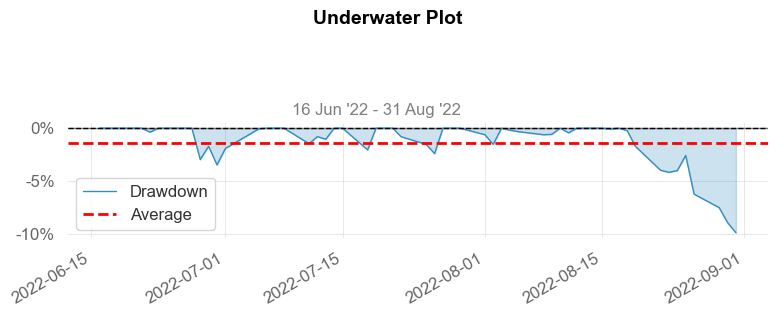

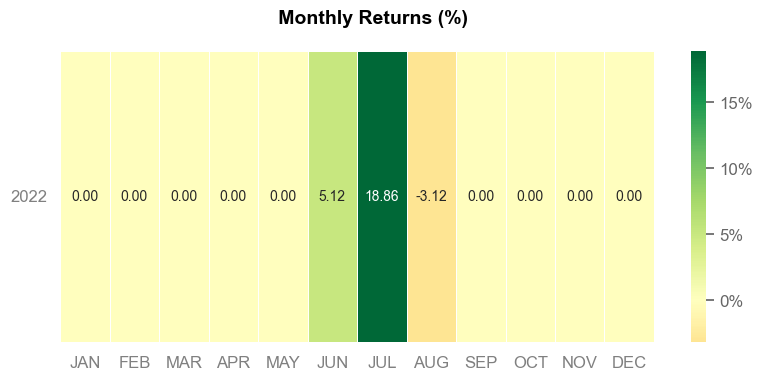

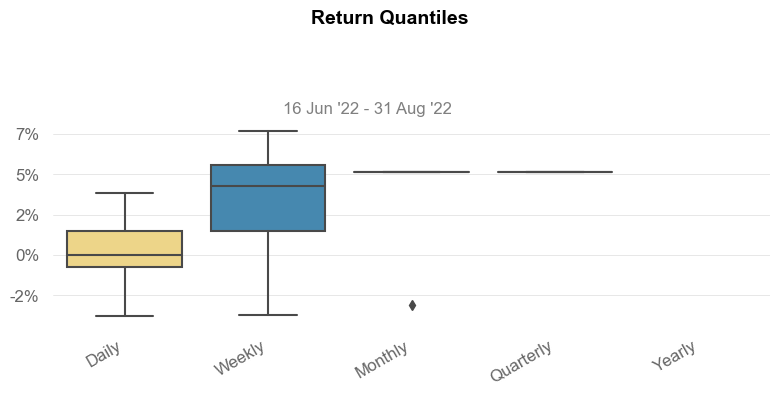

In [18]:
ModelwSentiment()

  0%|          | 0/1 [00:00<?, ?it/s]

Xhist.shape (172, 21)
yhist.shape (172, 1)
Xyhist.shape (172, 22)
ols.rsquared Date
2021-12-27         NaN
2021-12-28         NaN
2021-12-29         NaN
2021-12-30         NaN
2021-12-31         NaN
                ...   
2022-08-25    0.723901
2022-08-26    0.711571
2022-08-29    0.710078
2022-08-30    0.709023
2022-08-31    0.709395
Length: 172, dtype: float64


100%|██████████| 1/1 [00:00<00:00,  1.95it/s]

retsSpreads.index RangeIndex(start=0, stop=53, step=1)
type(retsSpreads.index) <class 'pandas.core.indexes.range.RangeIndex'>
type(retsSpreads['Date']) <class 'pandas.core.series.Series'>
type(retsSpreads['Date'][0]) <class 'datetime.date'>


                           Strategy
-------------------------  ----------
Start Period               2022-06-16
End Period                 2022-08-31
Risk-Free Rate             2.0%
Time in Market             99.0%

Cumulative Return          6.44%
CAGR﹪                     34.92%

Sharpe                     2.86
Prob. Sharpe Ratio         89.13%
Smart Sharpe               2.61
Sortino                    4.66
Smart Sortino              4.25
Sortino/√2                 3.29
Smart Sortino/√2           3.0
Omega                      1.58

Max Drawdown               -3.38%
Longest DD Days            15
Volatility (ann.)          9.86%
Calmar                     10.35
Skew                       -0.16
Kurtosis                   -0.32

Expected Daily %           0.12%
Expected Monthly %         2.1%
Expected Yearly %          6.44%
Kelly Criterion            21.54%
Risk of Ruin               0.0%
Daily Value-at-Risk        -0.9%
Expected Shortfall (cVaR)  -0.9%

Max Consecutive Wins       6
Ma

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2022-08-16,2022-08-31,2022-08-31,15,-3.375213,-2.905014
2,2022-06-28,2022-06-30,2022-07-07,9,-1.591329,-1.528072
3,2022-07-11,2022-07-12,2022-07-19,8,-1.451120,-1.377324
4,2022-08-05,2022-08-09,2022-08-10,5,-1.073387,-0.924646
5,2022-07-22,2022-07-26,2022-07-27,5,-0.714249,-0.350471


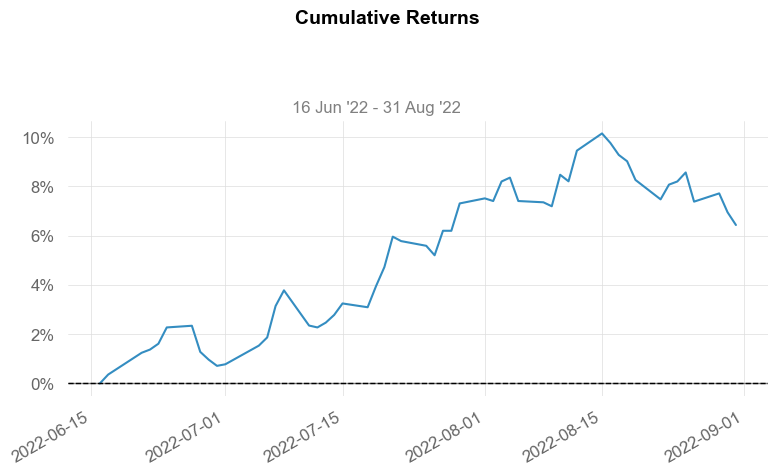

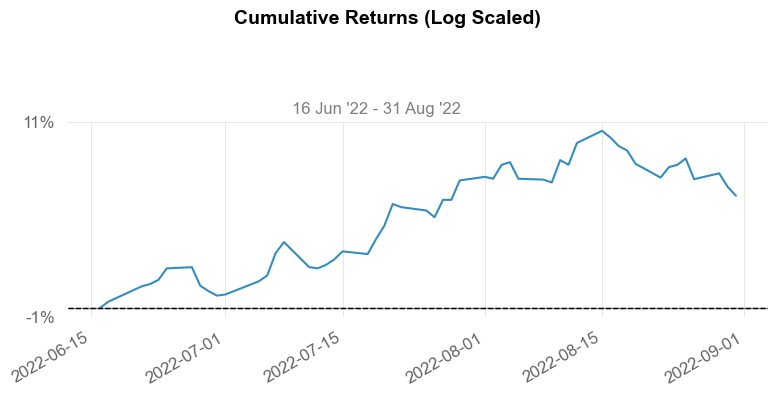

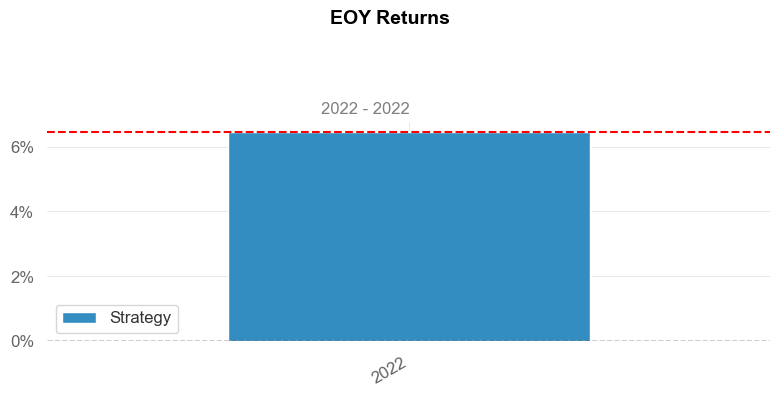

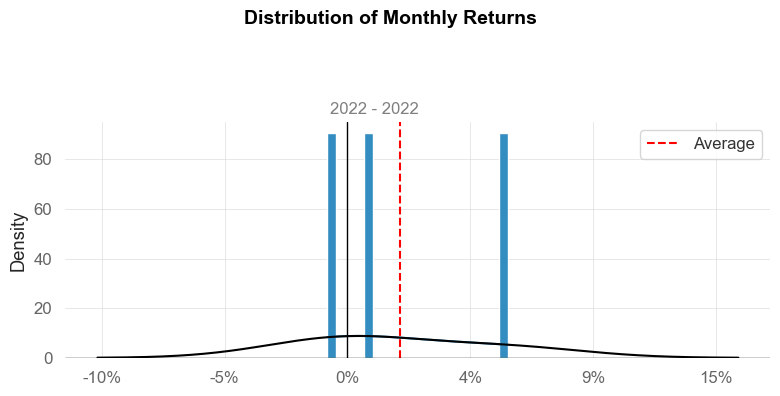

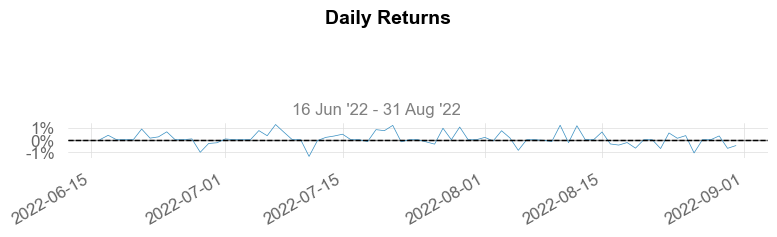

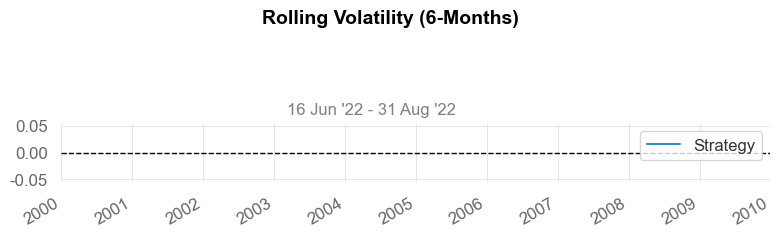

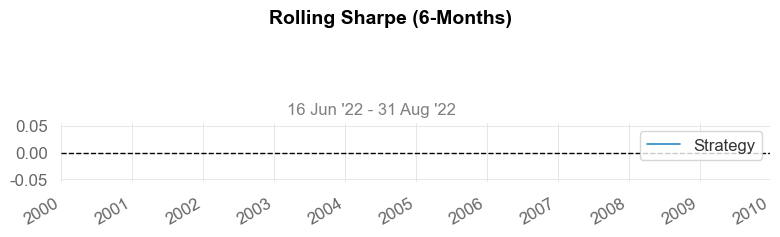

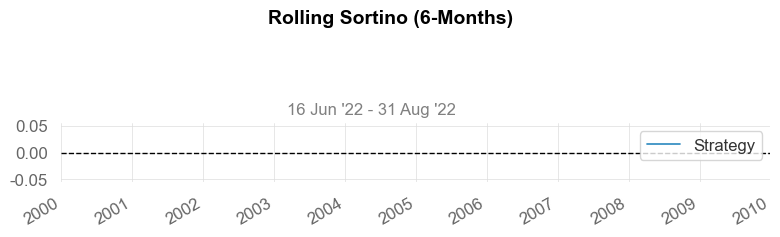

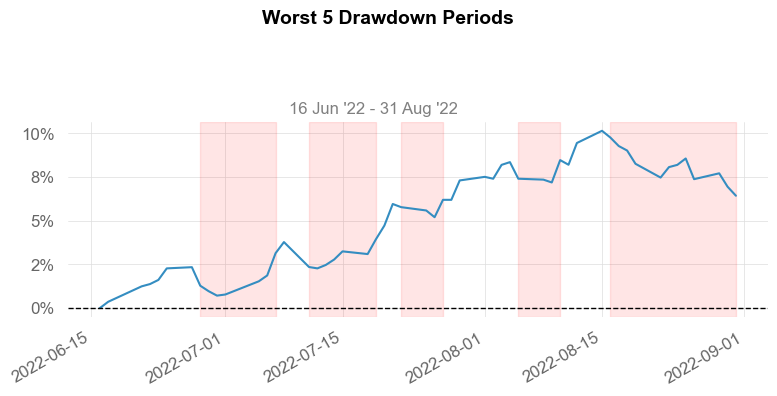

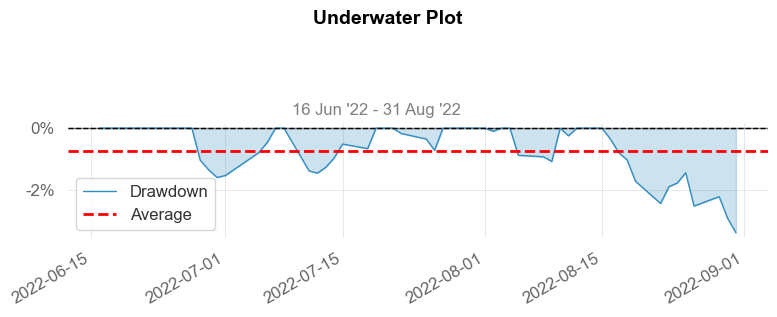

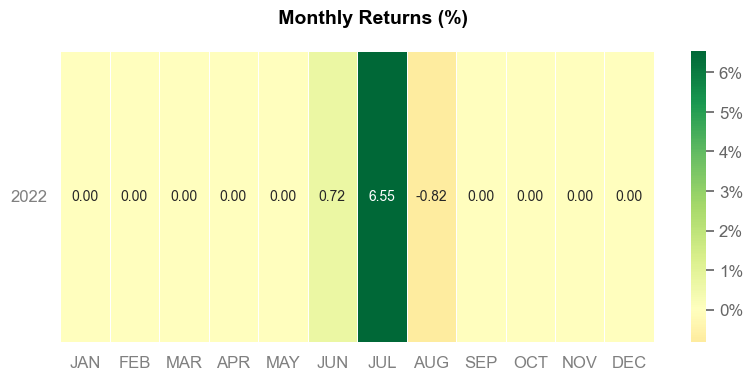

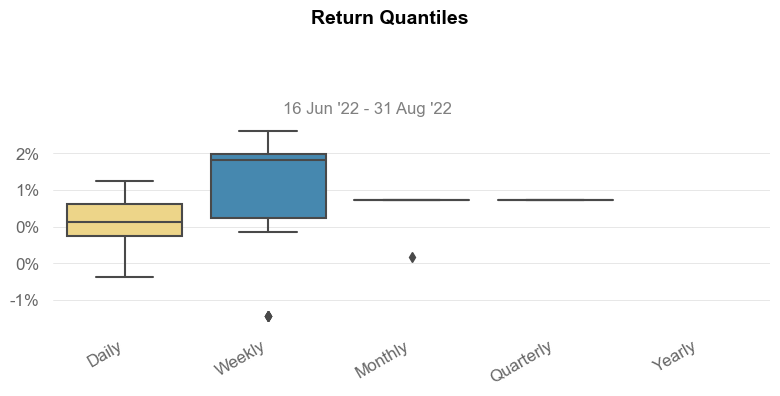

In [19]:
ModelwSentiment(tickers_to_predict=['TSLA'])

100%|██████████| 1/1 [00:00<00:00,  4.58it/s]

Xhist.shape (172, 21)
yhist.shape (172, 1)
Xyhist.shape (172, 22)
ols.rsquared Date
2021-12-27    NaN
2021-12-28    NaN
2021-12-29    NaN
2021-12-30    NaN
2021-12-31    NaN
             ... 
2022-08-25    1.0
2022-08-26    1.0
2022-08-29    1.0
2022-08-30    1.0
2022-08-31    1.0
Length: 172, dtype: float64
retsSpreads.index RangeIndex(start=0, stop=53, step=1)
type(retsSpreads.index) <class 'pandas.core.indexes.range.RangeIndex'>
type(retsSpreads['Date']) <class 'pandas.core.series.Series'>
type(retsSpreads['Date'][0]) <class 'datetime.date'>


                           Strategy
-------------------------  ----------
Start Period               2022-06-16
End Period                 2022-08-31
Risk-Free Rate             2.0%
Time in Market             99.0%

Cumulative Return          1.28%
CAGR﹪                     6.3%

Sharpe                     0.33
Prob. Sharpe Ratio         50.94%
Smart Sharpe               0.32
Sortino                    0.49
Smart Sortino              0.47
Sortino/√2                 0.35
Smart Sortino/√2           0.33
Omega                      1.06

Max Drawdown               -14.2%
Longest DD Days            40
Volatility (ann.)          51.32%
Calmar                     0.44
Skew                       0.12
Kurtosis                   -0.11

Expected Daily %           0.02%
Expected Monthly %         0.43%
Expected Yearly %          1.28%
Kelly Criterion            2.95%
Risk of Ruin               0.0%
Daily Value-at-Risk        -5.24%
Expected Shortfall (cVaR)  -5.24%

Max Consecutive Wins       5
Ma

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2022-07-22,2022-08-30,2022-08-31,40,-14.199921,-13.140794
2,2022-07-08,2022-07-14,2022-07-19,11,-8.211859,-5.406817
3,2022-06-27,2022-07-01,2022-07-07,10,-5.953223,-5.571233
4,2022-06-21,2022-06-22,2022-06-24,3,-4.818614,-4.085747


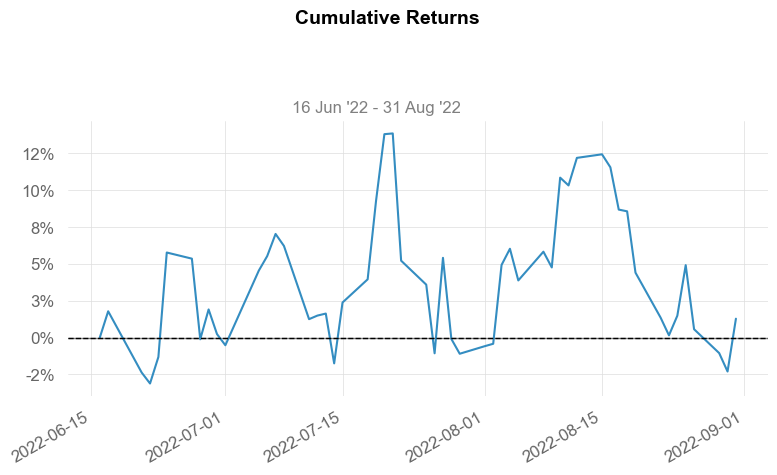

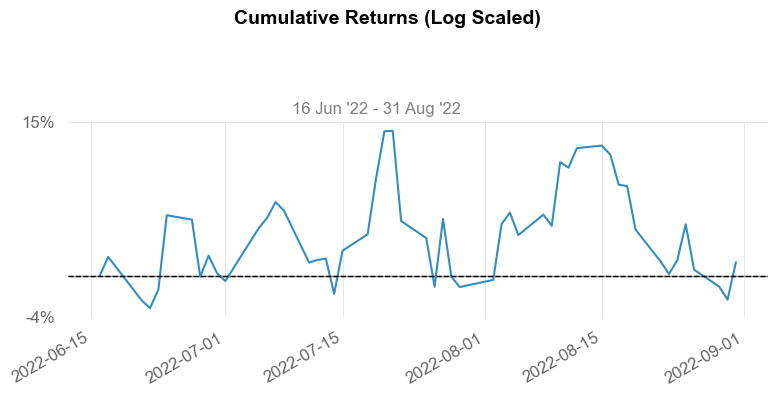

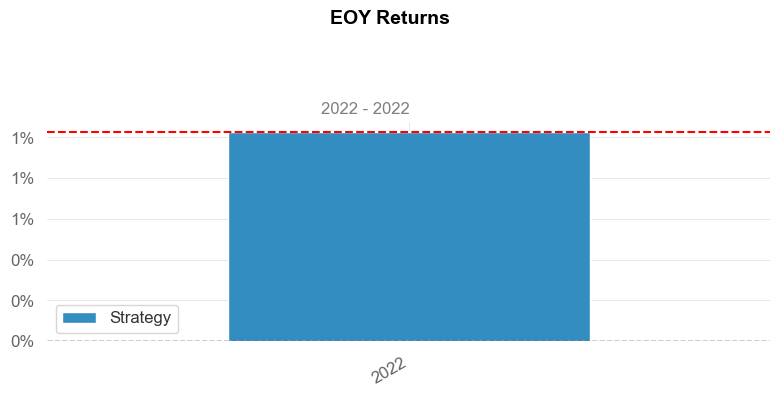

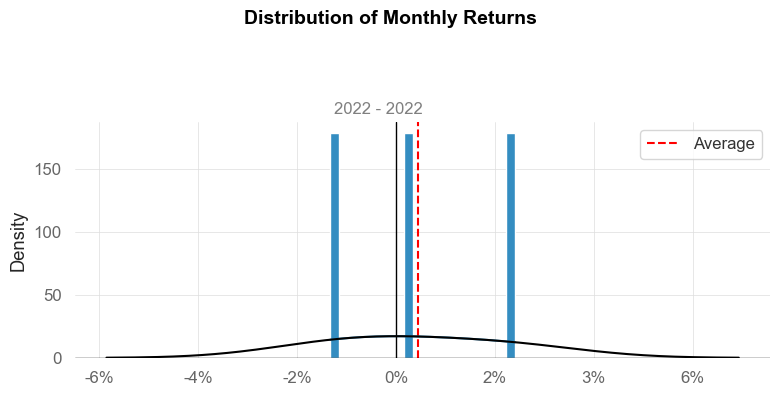

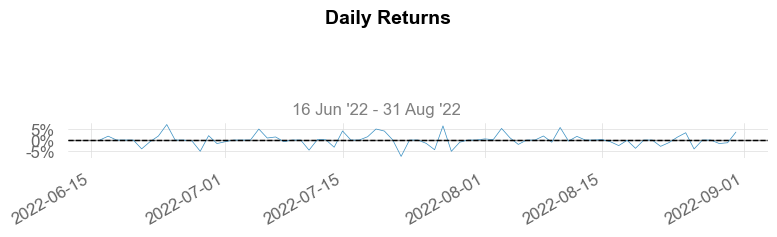

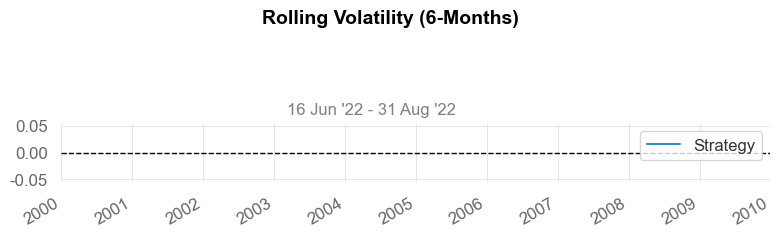

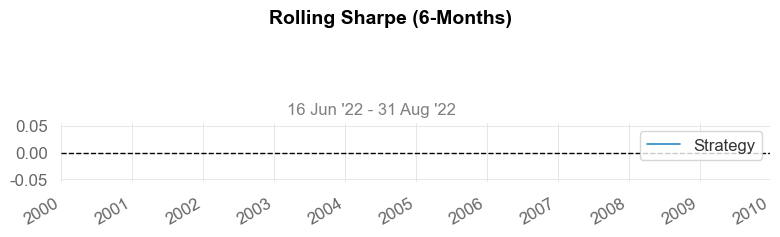

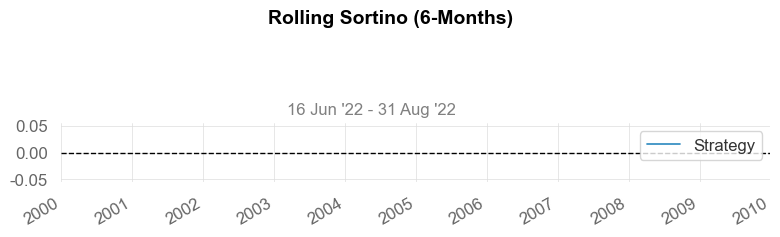

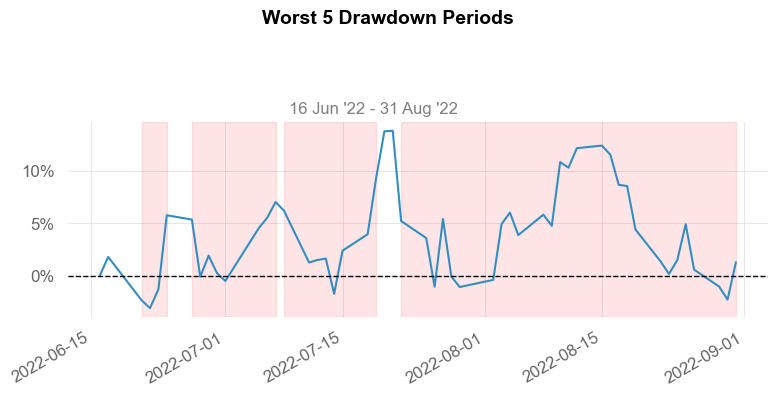

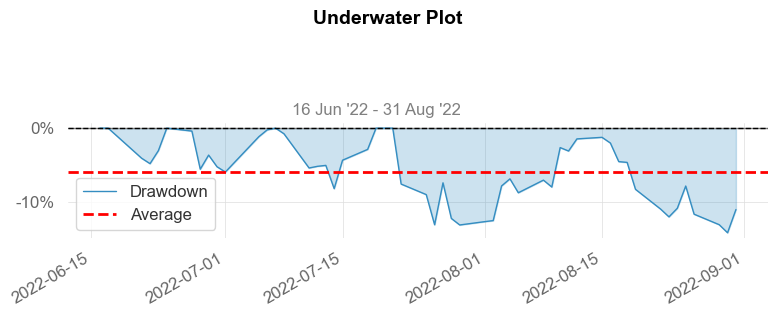

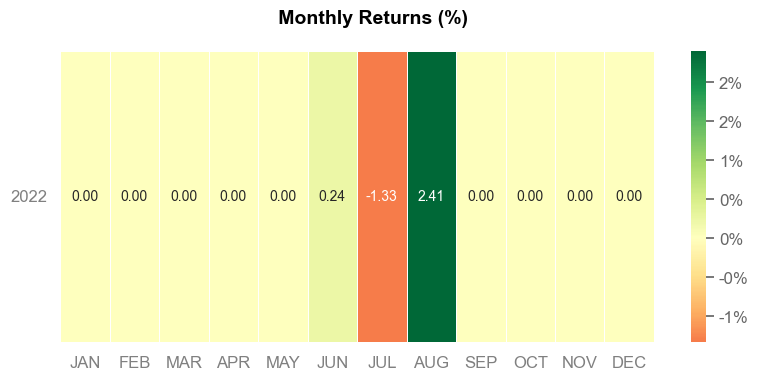

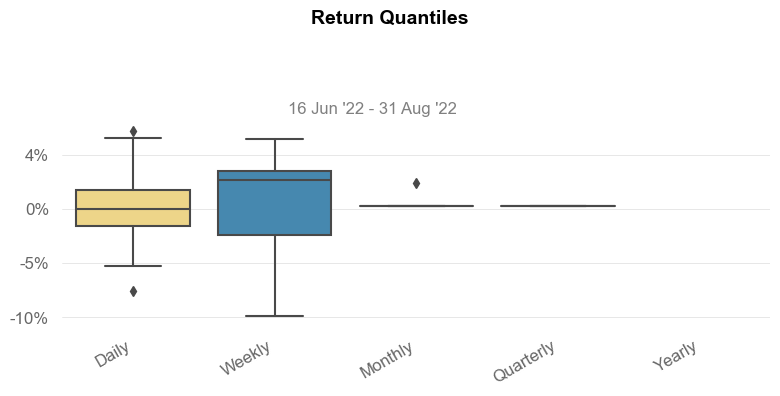

In [20]:
ModelwSentiment(tickers_to_predict=['META'])